In [10]:
d_l = 5
gen_layer_size = 64 # 64

In [11]:
import torch
import numpy as np
import random
import os

def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True

In [12]:
import torch
import torch.nn as nn
from torch.optim import SGD
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

import torch.distributions as TD
from zmq import device
import torch.optim as optim
from datetime import datetime
import functools
from tqdm import tqdm
import cv2

# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')

# Adding Noise to the dataset
def add_gaussian_noise(images, mean=0.0, std=1.0):
    noise = torch.randn_like(images) * std + mean
    noisy_images = images + noise
    noisy_images = torch.clamp(noisy_images, 0.0, 1.0)  # Ensure the values are still between 0 and 1
    return noisy_images

def motion_blur_kernel(length, angle):
    kernel = np.zeros((length, length))
    xs, ys = np.meshgrid(np.arange(length), np.arange(length))
    xs = xs - length // 2
    ys = ys - length // 2
    coords = np.stack([xs, ys], axis=-1)
    angle_rad = np.deg2rad(angle)
    direction = np.array([np.cos(angle_rad), np.sin(angle_rad)])
    dot_product = np.dot(coords, direction)
    kernel[np.abs(dot_product) < 0.5] = 1
    kernel /= kernel.sum() # normalize
    return kernel

def apply_motion_blur(image, length, angle):
    kernel = motion_blur_kernel(length, angle)
    kernel = kernel.astype(np.float32)
    image_np = image.squeeze().cpu().numpy()  # Convert to numpy array
    blurred_image_np = cv2.filter2D(image_np, -1, kernel, borderType=cv2.BORDER_REPLICATE)
    blurred_image = torch.tensor(blurred_image_np, dtype=torch.float32).unsqueeze(0).to(image.device)
    return blurred_image

def add_motion_blur_to_dataset(dataset):
    blurred_dataset = []
    for image in dataset:
        length = np.random.randint(6, 9)  # Random length between 4 and 6
        angle = np.random.uniform(0, 360)  # Random angle between 0 and 360 degrees
        blurred_image = apply_motion_blur(image, length, angle)
        blurred_dataset.append(blurred_image)

    return torch.stack(blurred_dataset)

def add_combine(dataset):
    motion_blur_dataset = add_motion_blur_to_dataset(dataset)
    add_guassian_noise_dataset = add_gaussian_noise(motion_blur_dataset)
    return add_guassian_noise_dataset

class CTDataset_image(Dataset):
    def __init__(self, filepath):
        self.flatten = nn.Flatten()
        self.x, self.y = torch.load(filepath, weights_only=False)
        self.x = self.x / 255.
        self.x = self.x.reshape(-1, 1, 28, 28).cuda().detach()
        self.y = F.one_hot(self.y, num_classes=10).to(float)

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]

def get_plot(x):
    x_temp = x.clone()
    x_np = x_temp.cpu().detach().numpy()
    # Create a figure with 10 rows and 4 columns
    fig, axes = plt.subplots(2, 4, figsize=(10, 5))

    # Plot the first 40 images
    for i in range(8):
        ax = axes[i // 4, i % 4]
        ax.imshow(x_np[i, 0], cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [13]:
setup_seed(42)  # You can choose any seed value
train_ds = CTDataset_image('./training.pt')
test_ds = CTDataset_image('./test.pt')

train_ds_x, train_ds_y = train_ds[:]
test_x_full_image, test_y_label = test_ds[:]

# Combine x and y into a single dataset
train_combined = torch.utils.data.TensorDataset(train_ds_x, train_ds_y)

setup_seed(42)  # You can choose any seed value
train_AE_set, train_cond_gen_set = torch.utils.data.random_split(train_combined, [30000, 30000])

# Separate the combined dataset back into x and y
train_AE_set_x_full_image = train_AE_set[:][0]
train_AE_set_y_label = train_AE_set[:][1]
train_cond_gen_set_x_full_image = train_cond_gen_set[:][0]
train_cond_gen_set_y_label = train_cond_gen_set[:][1]


In [14]:
setup_seed(42)  # You can choose any seed value
xs_noise_train_AE = add_combine(train_AE_set_x_full_image).to(device)

setup_seed(42)  # You can choose any seed value
xs_noise_train_gen = add_combine(train_cond_gen_set_x_full_image).to(device)

setup_seed(42)  # You can choose any seed value
xs_noise_test = add_combine(test_x_full_image).to(device)

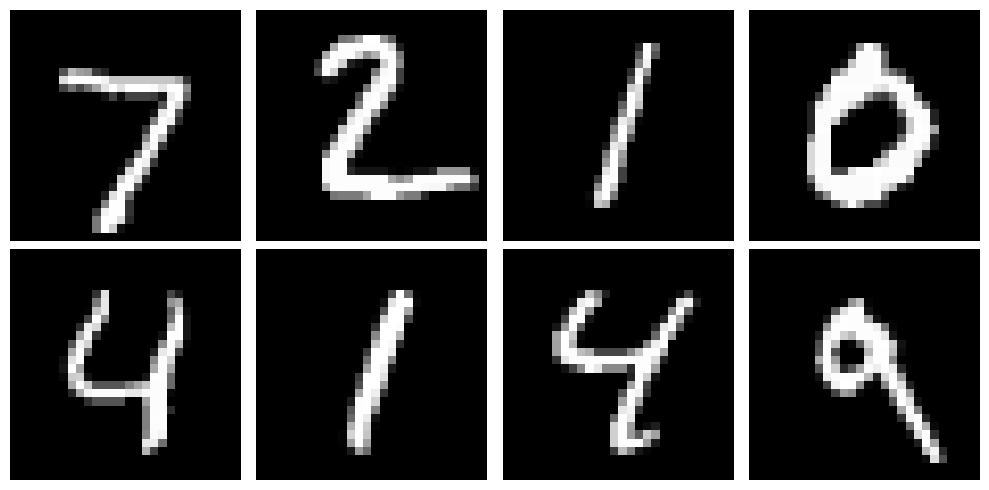

In [15]:
get_plot(test_x_full_image)

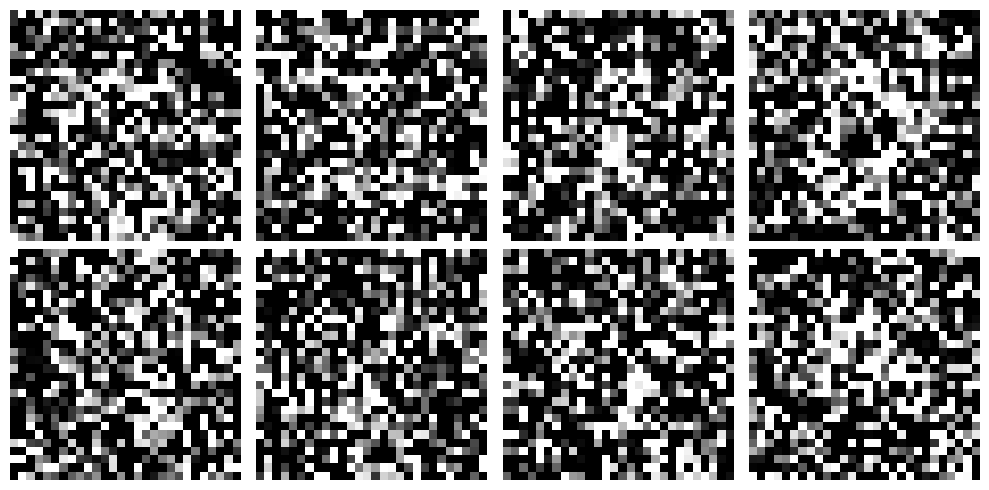

In [16]:
get_plot(xs_noise_test)

In [17]:
import torch
import torch.nn as nn

class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]

class AutoEncoder3(nn.Module):
    def __init__(self, d_l=d_l):
        super().__init__()

        self.encoder = nn.Sequential( #784
                nn.Conv2d(1, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 128, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(128, 128, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(128, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.Flatten(),
                nn.Linear(3136, d_l),
                nn.Tanh()
                # nn.Flatten(),
                # nn.Identity()
        )

        self.decoder = nn.Sequential(
                torch.nn.Linear(d_l, 3136),
                Reshape(-1, 64, 7, 7),
                nn.ConvTranspose2d(64, 128, stride=(1, 1), kernel_size=(3, 3), padding=1), # 64x7x7 -> 64x7x7
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(128, 128, stride=(2, 2), kernel_size=(3, 3), padding=1), # 64x7x7 -> 64x13x13
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(128, 64, stride=(2, 2), kernel_size=(3, 3), padding=0), # 64x13x13 -> 32x27x27
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 1, stride=(1, 1), kernel_size=(3, 3), padding=0), # 32x27x27 -> 1x29x29
                Trim(),  # 1x29x29 -> 1x28x28
                nn.Sigmoid()
        )

    def forward(self, x):
        x = F.interpolate(x, size=(28, 28), mode='nearest')
        x = self.encoder(x)
        # print(x.shape)
        x = self.decoder(x)
        return x

    def get_latent(self, x):
        x = F.interpolate(x, size=(28, 28), mode='nearest')
        x = self.encoder(x)
        return x

In [18]:
x_test_input = xs_noise_test.clone()
x_train_input = xs_noise_train_gen.clone()

import torch
from torch.utils.data import DataLoader, TensorDataset

# Assuming xs_train_AE and xs_test_AE are your input tensors
batch_size = 64  # Adjust the batch size based on your memory capacity

# Create DataLoaders

test_dataset = TensorDataset(x_test_input)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_dataset = TensorDataset(x_train_input)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# Function to compute latent representations
def compute_latent_representations(model, data_loader, device):
    latent_representations = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            batch = batch[0].to(device)  # Get the input tensor from the batch
            z_batch = model.get_latent(batch).detach()
            latent_representations.append(z_batch.cpu())
    return torch.cat(latent_representations, dim=0)

def compute_reconstructed_images(model, data_loader, device):
    reconstructed_images = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            batch = batch[0].to(device)  # Get the input tensor from the batch
            x_hat_batch = model(batch).detach()
            reconstructed_images.append(x_hat_batch.cpu())
    return torch.cat(reconstructed_images, dim=0)

model_AE = AutoEncoder3().to(device)
model_AE.load_state_dict(torch.load('path_to_trained_autoencoder.pth', weights_only=False))
# Compute latent representations for training and test data
x_recover_test_input = compute_reconstructed_images(model_AE, test_loader, device) # .reshape(x_test_input.shape[0], -1)
x_recover_train_input = compute_reconstructed_images(model_AE, train_loader, device) # .reshape(x_train_input.shape[0], -1)

print(x_recover_test_input.shape)
print(x_test_input.shape)

print(x_recover_train_input.shape)
print(x_train_input.shape)

torch.Size([10000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])
torch.Size([30000, 1, 28, 28])
torch.Size([30000, 1, 28, 28])


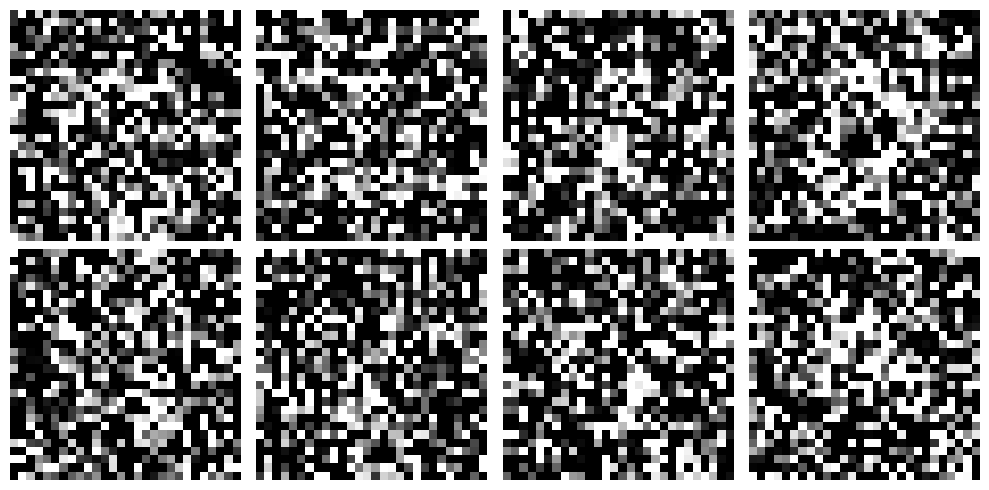

In [19]:
get_plot(xs_noise_test)

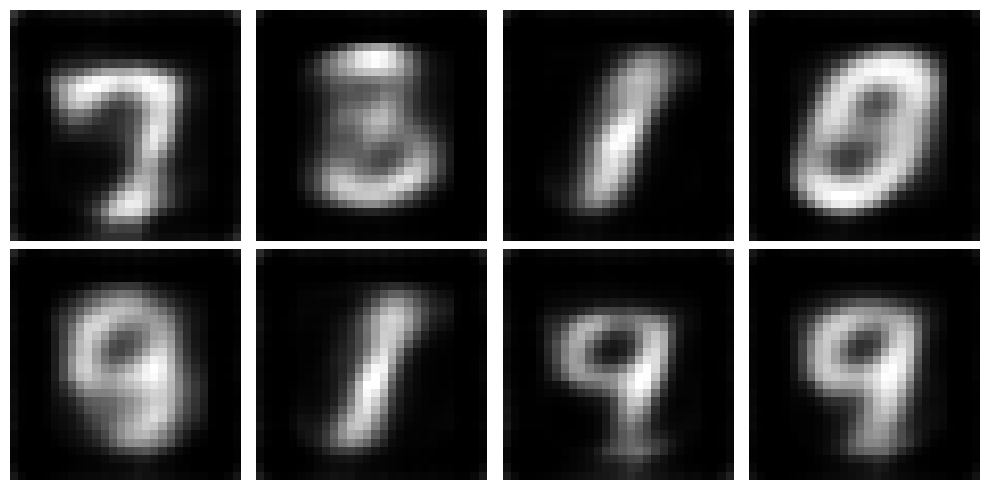

In [20]:
get_plot(x_recover_test_input)

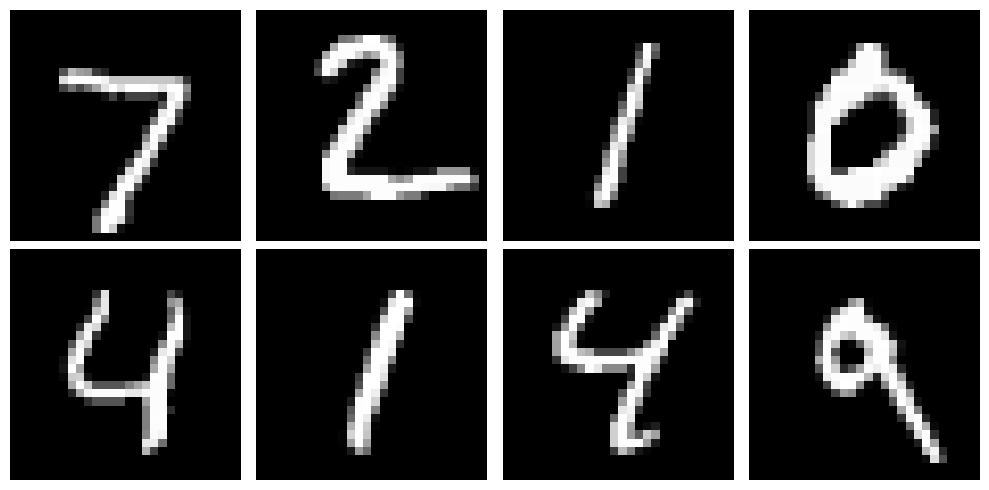

In [21]:
get_plot(test_x_full_image)

In [22]:
x_train_input = x_recover_train_input.reshape(x_recover_train_input.shape[0], -1).cpu().detach().numpy()
y_train_input = train_cond_gen_set_y_label.cpu().detach().numpy()

x_test_input = x_recover_test_input.reshape(x_recover_test_input.shape[0], -1).cpu().detach().numpy()
y_test_input = test_y_label.cpu().detach().numpy()

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
import math

classifiers = []
param_dist = {
    "n_neighbors":
    [i for i in range(1, int(math.sqrt(x_train_input.shape[0])))]
}
random_search = RandomizedSearchCV(
    KNeighborsClassifier(),
    param_distributions=param_dist,
    n_iter=60,
    cv=5,
    n_jobs=-1,
    random_state=42 )
classifiers.append(random_search.fit(x_train_input, y_train_input))

# Assuming x_test and y_test are already defined
test_accuracy = classifiers[0].score(x_test_input, y_test_input)
print(f" latent_space_dim: {d_l}; Test Accuracy: {test_accuracy}")

 latent_space_dim: 5; Test Accuracy: 0.2517
